> RoyChao

In [1]:
import sys
import logging

nblog = open("nb_light.log", "a+")
sys.stdout.echo = nblog
sys.stderr.echo = nblog

get_ipython().log.handlers[0].stream = nblog
get_ipython().log.setLevel(logging.INFO)

%autosave 5

Autosaving every 5 seconds


## 1-0 Environments

In [2]:
# Python:
!python3 --version

# Pip:
!pip --version

# matplotlob, numpy, pandas, sklearn, scipy, seaborn
import matplotlib
print('The matplotlib version is {}'. format(matplotlib. __version__)) 
import numpy as np
print('The numpy version is {}.'.format(np.__version__))
import pandas as pd
print('The pandas version is {}.'.format(pd.__version__))
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))
import scipy
print('The scipy version is {}.'.format(scipy.__version__))
import seaborn as sns
print('The seaborn version is {}.'.format(sns.__version__))

Python 3.9.7
pip 21.2.4 from /home/roy/miniconda3/envs/ry39/lib/python3.9/site-packages/pip (python 3.9)
The matplotlib version is 3.4.3
The numpy version is 1.20.3.
The pandas version is 1.3.3.
The scikit-learn version is 1.0.2.
The scipy version is 1.7.1.
The seaborn version is 0.11.2.


In [93]:
import joblib
print(joblib.__version__)

from lightgbm import LGBMRegressor
print(lightgbm.__version__)

1.1.0
3.3.2


## 1-1 Environments Parameters

In [3]:
sns.set( style="ticks" )

## 1-2 Read CSV & Drop

In [99]:
import glob
import pandas as pd
  
# specifying the path to csv files
path = "training_data"
  
# csv files in the path
files = glob.glob(path + "/*.csv")
  
# defining an empty list to store 
# content
data_frame = pd.DataFrame()
content = []
  
# checking all the csv files in the 
# specified path
for filename in files:
    
    # reading content of csv file
    # content.append(filename)
    df = pd.read_csv(filename, index_col=None)
    content.append(df)
  
# converting content to data frame
data_frame = pd.concat(content)
print(data_frame)

                     time  generation  consumption
0     2018-01-01 00:00:00        0.00         0.85
1     2018-01-01 01:00:00        0.73         0.79
2     2018-01-01 02:00:00        0.00         0.75
3     2018-01-01 03:00:00        0.00         0.68
4     2018-01-01 04:00:00        0.00         0.71
...                   ...         ...          ...
5827  2018-08-31 19:00:00        0.06         4.81
5828  2018-08-31 20:00:00        0.01         4.11
5829  2018-08-31 21:00:00        0.01         3.06
5830  2018-08-31 22:00:00        0.01         3.80
5831  2018-08-31 23:00:00        0.01         2.28

[291600 rows x 3 columns]


In [100]:
df_raw = data_frame
print(df_raw.head())

                  time  generation  consumption
0  2018-01-01 00:00:00        0.00         0.85
1  2018-01-01 01:00:00        0.73         0.79
2  2018-01-01 02:00:00        0.00         0.75
3  2018-01-01 03:00:00        0.00         0.68
4  2018-01-01 04:00:00        0.00         0.71


## 1-3 Make training dataframe

In [101]:
df_dataset = df_raw.copy()
"""
df_dataset['PRED'] = -1.0

for idx in range( len(df_dataset) - 1 ):
    df_dataset['PRED'][idx] = df_dataset['A'][idx + 1]

df_dataset.drop(df_dataset.tail(1).index, inplace=True)     # drop last one
"""
print( df_dataset.head() )
print( df_dataset.describe() )


                  time  generation  consumption
0  2018-01-01 00:00:00        0.00         0.85
1  2018-01-01 01:00:00        0.73         0.79
2  2018-01-01 02:00:00        0.00         0.75
3  2018-01-01 03:00:00        0.00         0.68
4  2018-01-01 04:00:00        0.00         0.71
          generation   consumption
count  291600.000000  291600.00000
mean        0.780644       1.44444
std         1.188958       1.27682
min         0.000000      -0.23000
25%         0.000000       0.50000
50%         0.020000       0.96000
75%         1.240000       1.98000
max         5.320000      10.65000


In [102]:
len(df_dataset) / 24

12150.0

In [103]:
df_dataset['time'] = pd.to_datetime(df_dataset['time'])
df_dataset.set_index('time', inplace=True)

In [104]:
df_all = []

for i in range( 24 ):
    df_all.append( df_dataset.loc[df_dataset.index.to_series().dt.hour == i] )

In [105]:
df_dataset = df_all.copy()

In [106]:
from scipy.stats import skew
from scipy.stats import kurtosis

"""
for i in range( 24 ):
    df_all[i] = df_all[i].resample('10080T').agg({'min', 'max', 'sum', skew, kurtosis})
"""

"\nfor i in range( 24 ):\n    df_all[i] = df_all[i].resample('10080T').agg({'min', 'max', 'sum', skew, kurtosis})\n"

In [107]:
df_target = []

for i in range( 24 ):
    tmp = df_dataset[i]['consumption'] - df_dataset[i]['generation']
    df_target.append(tmp)

In [108]:
df_all[0]

,generation,consumption
time,,
2018-01-01,0.00,0.85
2018-01-02,0.00,0.70
2018-01-03,0.00,0.39
2018-01-04,0.00,0.45
2018-01-05,0.00,0.28
...,...,...
2018-08-27,0.01,3.42
2018-08-28,0.01,2.49
2018-08-29,0.01,2.47


In [109]:
from scipy.stats import skew
from scipy.stats import kurtosis
from tqdm import tqdm

dataset_x = []
dataset_y = []

#df_feature.reset_index()

for t in range( 24 ):
    tmp_x = []
    tmp_y = []
    for i in tqdm( range(len(df_all[t]) - 6) ):
      #tmp_x.append(df_all[t].reset_index().drop('time', axis=1).iloc[ (i) : (i+7) ].agg({'min', 'max', 'sum', skew, kurtosis}).values.flatten())
      atmp = df_all[t].reset_index().drop('time', axis=1).iloc[ (i) : (i+7) ]
      aatmp = atmp.groupby(atmp.index // 7 ).agg({'min', 'max', 'sum', skew, kurtosis}).values[0]
      tmp_x.append(aatmp)
      tmp_y.append(df_target[t].iloc[ (i+7): (i+8)].values)

      #print(atmp)
      #print(aatmp)
      #print(tmp_x)
      #print(tmp_y)
    
    dataset_x.append(tmp_x)
    dataset_y.append(tmp_y)
    
for i in range( 24 ):
    dataset_x[i] = np.asarray(dataset_x[i])
    dataset_y[i] = np.asarray(dataset_y[i])

  6%|▌         | 702/12144 [00:04<01:06, 172.16it/s]


KeyboardInterrupt: 

In [110]:
print(dataset_x[0].shape)
print(dataset_y[0].shape)
print(dataset_x[0][0].shape)

IndexError: list index out of range

In [111]:
import pickle

#file = open("dataset_x.pickle", 'wb')
#pickle.dump(dataset_x, file)
#file.close()

#file = open("dataset_y.pickle", 'wb')
#pickle.dump(dataset_y, file)
#file.close()

#file = open("pretrained.pickle", 'rb')
#clf = pickle.load(file)
#file.close()

file = open("dataset_x.pickle", 'rb')
dataset_x = pickle.load(file)
file.close()

file = open("dataset_y.pickle", 'rb')
dataset_y = pickle.load(file)
file.close()

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
sns.set( style="ticks" )

In [18]:
from scipy.stats import skew
from scipy.stats import kurtosis

In [19]:
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
#import jpx_tokyo_market_prediction


from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split

In [20]:
!pip install optuna

In [36]:
GBM = []

import optuna

for t in range( 24 ):
    train_x = dataset_x[t][0:8500]
    train_y = dataset_y[t][0:8500]

    test_x = dataset_x[t][8500:]
    test_y = dataset_y[t][8500:]

    def objectives(trial):
        params = {
                'num_leaves': trial.suggest_int('num_leaves', 300, 8000),
                'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
                'max_bin': trial.suggest_int('max_bin', 2, 100),
                'learning_rate': trial.suggest_uniform('learning_rate',0, 1),
        }

        model = LGBMRegressor(**params)
        model.fit(train_x,train_y)
        score = model.score(train_x, train_y)
        return score

    studyLGBM = optuna.create_study(direction='maximize',sampler=optuna.samplers.RandomSampler(seed=0))
    studyLGBM.optimize(objectives, n_trials=10)

    trial = studyLGBM.best_trial
    params_best = dict(trial.params.items())
    params_best['random_seed'] = 0

    model = LGBMRegressor(**params_best)#

    model.fit(dataset_x[t][0:12143], dataset_y[t][0:12143])
    
    GBM.append(model)

[I 2022-05-21 15:48:18,732] A new study created in memory with name: no-name-125a3939-8858-49ae-88d8-902ba9821d5f
[I 2022-05-21 15:48:29,958] Trial 0 finished with value: 0.9317110711089946 and parameters: {'num_leaves': 4526, 'n_estimators': 718, 'max_bin': 61, 'learning_rate': 0.5448831829968969}. Best is trial 0 with value: 0.9317110711089946.
[I 2022-05-21 15:48:40,596] Trial 1 finished with value: 0.9197071507709036 and parameters: {'num_leaves': 3562, 'n_estimators': 650, 'max_bin': 45, 'learning_rate': 0.8917730007820798}. Best is trial 0 with value: 0.9317110711089946.
[I 2022-05-21 15:48:47,369] Trial 2 finished with value: 0.9378265957800187 and parameters: {'num_leaves': 7721, 'n_estimators': 389, 'max_bin': 80, 'learning_rate': 0.5288949197529045}. Best is trial 2 with value: 0.9378265957800187.
[I 2022-05-21 15:49:00,557] Trial 3 finished with value: 0.6878202953062142 and parameters: {'num_leaves': 4674, 'n_estimators': 927, 'max_bin': 9, 'learning_rate': 0.08712929970154

[I 2022-05-21 15:54:11,066] Trial 2 finished with value: 0.9449218416331185 and parameters: {'num_leaves': 7721, 'n_estimators': 389, 'max_bin': 80, 'learning_rate': 0.5288949197529045}. Best is trial 2 with value: 0.9449218416331185.
[I 2022-05-21 15:54:24,286] Trial 3 finished with value: 0.7247017046304767 and parameters: {'num_leaves': 4674, 'n_estimators': 927, 'max_bin': 9, 'learning_rate': 0.08712929970154071}. Best is trial 2 with value: 0.9449218416331185.
[I 2022-05-21 15:54:33,149] Trial 4 finished with value: 0.944773719520561 and parameters: {'num_leaves': 455, 'n_estimators': 835, 'max_bin': 79, 'learning_rate': 0.8700121482468192}. Best is trial 2 with value: 0.9449218416331185.
[I 2022-05-21 15:54:47,144] Trial 5 finished with value: 0.9230150719732245 and parameters: {'num_leaves': 7836, 'n_estimators': 801, 'max_bin': 47, 'learning_rate': 0.7805291762864555}. Best is trial 2 with value: 0.9449218416331185.
[I 2022-05-21 15:54:55,016] Trial 6 finished with value: 0.847

[I 2022-05-21 15:59:54,771] Trial 4 finished with value: 0.9371180225798904 and parameters: {'num_leaves': 455, 'n_estimators': 835, 'max_bin': 79, 'learning_rate': 0.8700121482468192}. Best is trial 4 with value: 0.9371180225798904.
[I 2022-05-21 16:00:08,338] Trial 5 finished with value: 0.921612137615794 and parameters: {'num_leaves': 7836, 'n_estimators': 801, 'max_bin': 47, 'learning_rate': 0.7805291762864555}. Best is trial 4 with value: 0.9371180225798904.
[I 2022-05-21 16:00:16,916] Trial 6 finished with value: 0.8521937523002018 and parameters: {'num_leaves': 1210, 'n_estimators': 644, 'max_bin': 16, 'learning_rate': 0.9446689170495839}. Best is trial 4 with value: 0.9371180225798904.
[I 2022-05-21 16:00:23,491] Trial 7 finished with value: 0.9042564719211715 and parameters: {'num_leaves': 4318, 'n_estimators': 420, 'max_bin': 28, 'learning_rate': 0.7742336894342167}. Best is trial 4 with value: 0.9371180225798904.
[I 2022-05-21 16:00:27,642] Trial 8 finished with value: 0.296

[I 2022-05-21 16:05:46,219] Trial 6 finished with value: 0.9447068800918609 and parameters: {'num_leaves': 1210, 'n_estimators': 644, 'max_bin': 16, 'learning_rate': 0.9446689170495839}. Best is trial 4 with value: 0.995346316141252.
[I 2022-05-21 16:05:52,689] Trial 7 finished with value: 0.9732270554850438 and parameters: {'num_leaves': 4318, 'n_estimators': 420, 'max_bin': 28, 'learning_rate': 0.7742336894342167}. Best is trial 4 with value: 0.995346316141252.
[I 2022-05-21 16:05:57,337] Trial 8 finished with value: 0.2804377931127573 and parameters: {'num_leaves': 3812, 'n_estimators': 573, 'max_bin': 3, 'learning_rate': 0.6176354970758771}. Best is trial 4 with value: 0.995346316141252.
[I 2022-05-21 16:06:08,216] Trial 9 finished with value: 0.9952809540955921 and parameters: {'num_leaves': 5013, 'n_estimators': 621, 'max_bin': 95, 'learning_rate': 0.6818202991034834}. Best is trial 4 with value: 0.995346316141252.
[I 2022-05-21 16:06:20,206] A new study created in memory with na

[I 2022-05-21 16:11:26,737] Trial 8 finished with value: 0.2854204413614374 and parameters: {'num_leaves': 3812, 'n_estimators': 573, 'max_bin': 3, 'learning_rate': 0.6176354970758771}. Best is trial 4 with value: 0.9960585715855198.
[I 2022-05-21 16:11:37,547] Trial 9 finished with value: 0.9974502072763096 and parameters: {'num_leaves': 5013, 'n_estimators': 621, 'max_bin': 95, 'learning_rate': 0.6818202991034834}. Best is trial 9 with value: 0.9974502072763096.
[I 2022-05-21 16:11:51,814] A new study created in memory with name: no-name-5d41d08b-8573-40ad-8ade-9df31623110d
[I 2022-05-21 16:12:02,987] Trial 0 finished with value: 0.993901374622197 and parameters: {'num_leaves': 4526, 'n_estimators': 718, 'max_bin': 61, 'learning_rate': 0.5448831829968969}. Best is trial 0 with value: 0.993901374622197.
[I 2022-05-21 16:12:12,847] Trial 1 finished with value: 0.990654278748943 and parameters: {'num_leaves': 3562, 'n_estimators': 650, 'max_bin': 45, 'learning_rate': 0.8917730007820798}

[I 2022-05-21 16:17:20,581] A new study created in memory with name: no-name-8f2391e9-cb65-48cf-a48e-4c9373c48a9d
[I 2022-05-21 16:17:32,429] Trial 0 finished with value: 0.996641972732658 and parameters: {'num_leaves': 4526, 'n_estimators': 718, 'max_bin': 61, 'learning_rate': 0.5448831829968969}. Best is trial 0 with value: 0.996641972732658.
[I 2022-05-21 16:17:42,289] Trial 1 finished with value: 0.9891832510251731 and parameters: {'num_leaves': 3562, 'n_estimators': 650, 'max_bin': 45, 'learning_rate': 0.8917730007820798}. Best is trial 0 with value: 0.996641972732658.
[I 2022-05-21 16:17:48,950] Trial 2 finished with value: 0.9958840133353009 and parameters: {'num_leaves': 7721, 'n_estimators': 389, 'max_bin': 80, 'learning_rate': 0.5288949197529045}. Best is trial 0 with value: 0.996641972732658.
[I 2022-05-21 16:18:03,100] Trial 3 finished with value: 0.9072537556123617 and parameters: {'num_leaves': 4674, 'n_estimators': 927, 'max_bin': 9, 'learning_rate': 0.08712929970154071}

[I 2022-05-21 16:23:20,310] Trial 2 finished with value: 0.9842499336397854 and parameters: {'num_leaves': 7721, 'n_estimators': 389, 'max_bin': 80, 'learning_rate': 0.5288949197529045}. Best is trial 2 with value: 0.9842499336397854.
[I 2022-05-21 16:23:34,487] Trial 3 finished with value: 0.9015702255498269 and parameters: {'num_leaves': 4674, 'n_estimators': 927, 'max_bin': 9, 'learning_rate': 0.08712929970154071}. Best is trial 2 with value: 0.9842499336397854.
[I 2022-05-21 16:23:43,329] Trial 4 finished with value: 0.9856524219452861 and parameters: {'num_leaves': 455, 'n_estimators': 835, 'max_bin': 79, 'learning_rate': 0.8700121482468192}. Best is trial 4 with value: 0.9856524219452861.
[I 2022-05-21 16:23:56,659] Trial 5 finished with value: 0.9774500769850628 and parameters: {'num_leaves': 7836, 'n_estimators': 801, 'max_bin': 47, 'learning_rate': 0.7805291762864555}. Best is trial 4 with value: 0.9856524219452861.
[I 2022-05-21 16:24:05,343] Trial 6 finished with value: 0.94

[I 2022-05-21 16:29:11,473] Trial 4 finished with value: 0.9372671293161223 and parameters: {'num_leaves': 455, 'n_estimators': 835, 'max_bin': 79, 'learning_rate': 0.8700121482468192}. Best is trial 4 with value: 0.9372671293161223.
[I 2022-05-21 16:29:25,011] Trial 5 finished with value: 0.9167988564898464 and parameters: {'num_leaves': 7836, 'n_estimators': 801, 'max_bin': 47, 'learning_rate': 0.7805291762864555}. Best is trial 4 with value: 0.9372671293161223.
[I 2022-05-21 16:29:32,883] Trial 6 finished with value: 0.8512599546501483 and parameters: {'num_leaves': 1210, 'n_estimators': 644, 'max_bin': 16, 'learning_rate': 0.9446689170495839}. Best is trial 4 with value: 0.9372671293161223.
[I 2022-05-21 16:29:39,307] Trial 7 finished with value: 0.898072599355836 and parameters: {'num_leaves': 4318, 'n_estimators': 420, 'max_bin': 28, 'learning_rate': 0.7742336894342167}. Best is trial 4 with value: 0.9372671293161223.
[I 2022-05-21 16:29:41,527] Trial 8 finished with value: 0.378

In [37]:
from sklearn import datasets
##########################
# SAVE-LOAD using joblib #
##########################
import joblib

# save
joblib.dump(GBM, "gbm.pkl") 

# load
clff = joblib.load("gbm.pkl")

In [54]:
round(145.314141, 2)

145.31

In [59]:
dd1 = pd.read_csv("sample_data/consumption.csv", index_col=None)
dd2 = pd.read_csv("sample_data/generation.csv", index_col=None)
#dd1 = pd.read_csv(args.consumption, index_col=None)
#dd2 = pd.read_csv(args.generation, index_col=None)

dd1['generation'] = dd2['generation'].copy()
dd1['time'] = pd.to_datetime(dd1['time'])
dd1.set_index('time', inplace=True)

df_all = []
for i in range( 24 ):
    df_all.append( dd1.loc[dd1.index.to_series().dt.hour == i] )
    
print(df_all[0])

            consumption  generation
time                               
2018-08-25         2.63        0.00
2018-08-26         2.33        0.00
2018-08-27         1.80        0.00
2018-08-28         1.84        0.00
2018-08-29         2.31        0.00
2018-08-30         1.89        0.00
2018-08-31         1.26        0.01


In [94]:
import joblib
clf = joblib.load("gbm.pkl")

dd1 = pd.read_csv("sample_data/consumption.csv", index_col=None)
dd2 = pd.read_csv("sample_data/generation.csv", index_col=None)
#dd1 = pd.read_csv(args.consumption, index_col=None)
#dd2 = pd.read_csv(args.generation, index_col=None)

dd1['generation'] = dd2['generation'].copy()
dd1['time'] = pd.to_datetime(dd1['time'])
dd1.set_index('time', inplace=True)

df_all = []
for i in range( 24 ):
    df_all.append( dd1.loc[dd1.index.to_series().dt.hour == i] )

dataset_x = []
for t in range( 24 ):
    tmp_x = []
    atmp = df_all[t].reset_index().drop('time', axis=1).iloc[:]
    aatmp = atmp.groupby(atmp.index // 7 ).agg({'min', 'max', 'sum', skew, kurtosis}).values
    tmp_x.append(aatmp)

    dataset_x.append(tmp_x)
#print(dataset_x)

for i in range( 24 ):
    dataset_x[i] = np.asarray(dataset_x[i])

    
output = []
for t in range(24):
    one_col = []
    pred = clf[t].predict(dataset_x[t][0])[0]

    # Time
    one_col.append(str(dd1.index[-1] + pd.DateOffset(hours=t+1)))
    # buy or sell
    if pred >= 0:
        one_col.append("buy")
        # prices
        one_col.append(2.51)
        # volume
        one_col.append(round(pred, 2))
    else:
        one_col.append("sell")
        # prices
        one_col.append(0.01)
        # volumn
        one_col.append(round(pred * -1, 2))

    print(one_col)
    output.append(one_col)
    
    one_col = []
    # Time
    one_col.append(str(dd1.index[-1] + pd.DateOffset(hours=t+1)))
    # buy or sell
    if pred >= 0:
        one_col.append("buy")
        one_col.append(0)
        one_col.append(300)
    else:
        one_col.append("sell")
        one_col.append(300)
        one_col.append(300)

    print(one_col)

print(output)
#output(args.output, data)

['2018-09-01 00:00:00', 'buy', 2.51, 2.04]
['2018-09-01 00:00:00', 'buy', 0, 300]
['2018-09-01 01:00:00', 'buy', 2.51, 0.01]
['2018-09-01 01:00:00', 'buy', 0, 300]
['2018-09-01 02:00:00', 'buy', 2.51, 0.14]
['2018-09-01 02:00:00', 'buy', 0, 300]
['2018-09-01 03:00:00', 'buy', 2.51, 0.43]
['2018-09-01 03:00:00', 'buy', 0, 300]
['2018-09-01 04:00:00', 'buy', 2.51, 0.26]
['2018-09-01 04:00:00', 'buy', 0, 300]
['2018-09-01 05:00:00', 'buy', 2.51, 0.14]
['2018-09-01 05:00:00', 'buy', 0, 300]
['2018-09-01 06:00:00', 'buy', 2.51, 0.57]
['2018-09-01 06:00:00', 'buy', 0, 300]
['2018-09-01 07:00:00', 'buy', 2.51, 0.44]
['2018-09-01 07:00:00', 'buy', 0, 300]
['2018-09-01 08:00:00', 'sell', 0.01, 0.33]
['2018-09-01 08:00:00', 'sell', 300, 300]
['2018-09-01 09:00:00', 'sell', 0.01, 1.14]
['2018-09-01 09:00:00', 'sell', 300, 300]
['2018-09-01 10:00:00', 'sell', 0.01, 2.29]
['2018-09-01 10:00:00', 'sell', 300, 300]
['2018-09-01 11:00:00', 'sell', 0.01, 0.11]
['2018-09-01 11:00:00', 'sell', 300, 300]


In [79]:
dataset_x[0][0]

array([[ 1.40600000e+01, -2.61773140e-01,  1.26000000e+00,
        -7.44010989e-01,  2.63000000e+00,  1.00000000e-02,
         2.04124145e+00,  0.00000000e+00,  2.16666667e+00,
         1.00000000e-02]])

In [47]:
dd1.index[-1] + pd.DateOffset(hours=1)

Timestamp('2018-09-01 00:00:00')

In [25]:
import optuna

studyLGBM = optuna.create_study(direction='maximize',sampler=optuna.samplers.RandomSampler(seed=0))
studyLGBM.optimize(objectives, n_trials=10)

trial = studyLGBM.best_trial
params_best = dict(trial.params.items())
params_best['random_seed'] = 0
    
model = LGBMRegressor(**params_best)#

[I 2022-05-21 15:40:28,867] A new study created in memory with name: no-name-c4c31a56-4a1e-419b-9b3c-25b2938fa210
[I 2022-05-21 15:40:34,789] Trial 0 finished with value: 0.9317110711089946 and parameters: {'num_leaves': 4526, 'n_estimators': 718, 'max_bin': 61, 'learning_rate': 0.5448831829968969}. Best is trial 0 with value: 0.9317110711089946.
[I 2022-05-21 15:40:39,879] Trial 1 finished with value: 0.9197071507709036 and parameters: {'num_leaves': 3562, 'n_estimators': 650, 'max_bin': 45, 'learning_rate': 0.8917730007820798}. Best is trial 0 with value: 0.9317110711089946.
[I 2022-05-21 15:40:43,296] Trial 2 finished with value: 0.9378265957800187 and parameters: {'num_leaves': 7721, 'n_estimators': 389, 'max_bin': 80, 'learning_rate': 0.5288949197529045}. Best is trial 2 with value: 0.9378265957800187.
[I 2022-05-21 15:40:50,150] Trial 3 finished with value: 0.6878202953062142 and parameters: {'num_leaves': 4674, 'n_estimators': 927, 'max_bin': 9, 'learning_rate': 0.08712929970154

In [27]:
model.fit(dataset_x[t][0:12143], dataset_y[t][0:12143])

LGBMRegressor(learning_rate=0.6818202991034834, max_bin=95, n_estimators=621,
              num_leaves=5013, random_seed=0)

In [112]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

pred_list = []
true_list = []
for t in range(24):
    mse = 0
    mae = 0
    for i in range(len(dataset_x[t]) - 1):
        pred = clff[t].predict(dataset_x[t][i,:].reshape(1,-1))
        true = dataset_y[t][i]
        mae += mean_absolute_error(true, pred)
        mse += mean_squared_error(true, pred)
        
        print(pred)
        
        pred_list.append(pred)
        true_list.append(true)
    fsefsf
    
    print(f"MAE: {mae}, MSE: {mse}")

[-0.20348717]
[0.16376701]
[0.56348178]
[0.26588557]
[0.70404993]
[0.86475382]
[0.31606123]
[0.43343588]
[0.50298272]
[0.18586121]
[0.72085567]
[0.96202662]
[0.83441984]
[0.47100513]
[0.33291824]
[0.23863903]
[0.66746208]
[0.57905399]
[0.31132309]
[0.48537639]
[0.32247741]
[0.67702046]
[0.42160902]
[0.6383686]
[0.34318473]
[-0.0335965]
[2.75695035]
[0.31606123]
[0.05554901]
[0.70496971]
[0.37758152]
[0.36330306]
[0.16906451]
[0.47024351]
[0.31606123]
[0.55744667]
[0.08230954]
[0.01068265]
[0.56354132]
[0.72255985]
[0.09791708]
[0.34941169]
[-0.04243081]
[0.18190447]
[0.53146867]
[0.2378657]
[0.56105697]
[0.38934752]
[0.31606123]
[0.61191049]
[0.6456357]
[0.37624952]
[0.30499]
[0.07747951]
[-0.03083357]
[0.36860414]
[0.36759854]
[0.31380341]
[-0.07021758]
[-0.04413013]
[0.44629154]
[0.19532864]
[0.35184342]
[0.95166652]
[0.80945158]
[0.33535448]
[0.26619834]
[0.519966]
[0.52613372]
[2.57863685]
[1.09331523]
[0.63558054]
[1.20118378]
[1.09943115]
[1.47732468]
[0.72160312]
[0.7974256]
[0.

[4.9799413]
[4.76775595]
[4.14300291]
[4.52651716]
[4.10213792]
[4.96770594]
[1.69862656]
[3.99894727]
[3.25355552]
[3.13110531]
[4.22107604]
[4.22088078]
[4.543263]
[4.46047171]
[3.99894727]
[5.54654246]
[3.67797932]
[3.98842173]
[3.32632938]
[3.66661245]
[4.97308331]
[4.41682823]
[4.66231606]
[3.62021308]
[2.41907423]
[2.9596289]
[5.55358164]
[5.67071654]
[3.19437521]
[4.70047346]
[3.52692737]
[4.57559667]
[4.55295073]
[4.1069755]
[5.46058242]
[2.7185845]
[1.87216151]
[1.19558462]
[0.59947989]
[0.29791771]
[0.3041247]
[1.0724576]
[0.69070014]
[0.96364245]
[0.65544947]
[0.31191429]
[0.58388157]
[0.43045677]
[0.30599644]
[0.60314753]
[0.26857578]
[0.04741861]
[0.02954696]
[0.22133096]
[0.10326901]
[0.37909185]
[1.69662289]
[1.32273462]
[1.26867067]
[0.83728578]
[0.93033904]
[0.58801468]
[1.75227496]
[0.48385239]
[0.52932667]
[0.91592401]
[0.23011078]
[1.04064067]
[0.90547602]
[0.2687293]
[0.82153819]
[0.30770677]
[0.37896377]
[0.45647107]
[1.09021931]
[0.57142426]
[0.64017196]
[0.85424

[0.79844909]
[0.64381862]
[1.72394036]
[2.46958214]
[3.84299836]
[1.97346452]
[2.17742834]
[0.61120714]
[2.17135973]
[0.47316058]
[0.67182901]
[1.88003284]
[2.82164213]
[1.11987328]
[1.92482385]
[2.95438324]
[2.68686247]
[3.71408857]
[1.93940815]
[2.2733848]
[0.92457066]
[2.87504806]
[3.08774257]
[1.81778649]
[1.61259232]
[1.6157073]
[2.94019559]
[4.08849097]
[4.12946658]
[4.01145205]
[1.72671688]
[0.65220683]
[2.77422174]
[1.80215461]
[2.8112266]
[2.71519916]
[0.91018757]
[1.67311609]
[0.6137127]
[1.24738011]
[1.28307807]
[2.19077723]
[2.24512488]
[2.4248466]
[3.23826902]
[0.54647588]
[1.66505487]
[2.42248084]
[3.57621774]
[5.12856949]
[1.2204776]
[2.57027098]
[1.64684058]
[3.689291]
[1.05703925]
[1.27830692]
[1.08561154]
[1.28844996]
[1.71507421]
[1.74263091]
[2.44967178]
[-0.23136197]
[1.48058273]
[5.88523526]
[6.18280141]
[2.27236463]
[1.5085538]
[3.689291]
[4.63684278]
[2.61946574]
[2.97017547]
[4.13710533]
[4.94612556]
[1.20236859]
[1.31611341]
[2.03178847]
[1.28027247]
[1.144160

[0.28004843]
[0.76370506]
[0.46425674]
[0.31528486]
[0.48212145]
[0.60036153]
[0.42703751]
[0.27943587]
[0.23555661]
[0.75741001]
[0.69086345]
[0.49344651]
[0.54378065]
[0.44264385]
[0.06602368]
[0.3224261]
[0.35184342]
[0.19196547]
[0.35230362]
[0.21122287]
[0.50644218]
[0.57142426]
[0.66395569]
[0.74428247]
[0.33676485]
[0.20263634]
[0.20026111]
[0.69408662]
[0.05875184]
[-0.14457865]
[0.56069581]
[0.43183588]
[0.39295721]
[0.42602174]
[0.62113699]
[0.20226962]
[0.54109995]
[0.56069581]
[0.12035716]
[0.00848681]
[0.35875829]
[0.18347287]
[0.23783013]
[-0.14457865]
[0.46425674]
[0.38677395]
[0.38225769]
[0.62294568]
[0.66430594]
[0.11998867]
[-0.01871285]
[0.30055376]
[0.71180736]
[0.72060655]
[0.65626817]
[0.20524002]
[1.49892849]
[0.68828322]
[0.56519264]
[0.62207925]
[0.41623335]
[1.52678068]
[1.59757682]
[1.43028638]
[0.43868665]
[0.56519264]
[0.0751908]
[0.50110304]
[0.71712569]
[0.73994914]
[0.85366572]
[0.15446474]
[0.95749761]
[1.52337628]
[1.15873561]
[0.9104541]
[0.90010039]

[1.96665986]
[2.61283064]
[2.23584029]
[2.85478035]
[1.66036839]
[3.42175266]
[0.74751013]
[0.37158026]
[0.65484029]
[0.10605201]
[0.2998641]
[0.54912087]
[0.27106205]
[0.38963202]
[0.59960074]
[0.27762246]
[0.06968415]
[0.43959816]
[0.56845585]
[0.34832922]
[0.60314753]
[0.32076224]
[0.2233774]
[0.31248518]
[0.16423542]
[0.16138984]
[0.27106205]
[0.38963202]
[0.32018656]
[0.30225037]
[0.17171854]
[0.19026537]
[0.51781345]
[0.40473847]
[0.38963202]
[0.21505665]
[-0.27568282]
[0.29261447]
[0.63938701]
[0.14133055]
[0.61364868]
[0.52099618]
[0.3967735]
[0.37191078]
[0.38237646]
[0.18825374]
[0.41616161]
[0.0494075]
[0.32247741]
[0.19572692]
[0.59662088]
[0.6099847]
[0.07784839]
[0.21897631]
[0.27712917]
[0.32247741]
[0.54833141]
[0.57880842]
[0.29975387]
[0.46121895]
[0.39460962]
[0.21760793]
[0.38963202]
[0.22052474]
[0.42348043]
[0.45767354]
[0.40255707]
[0.09896528]
[0.1173801]
[0.52074989]
[0.3276481]
[0.01143513]
[0.40953711]
[0.39554524]
[0.20723498]
[0.3798404]
[0.32247741]
[0.379

[0.67008426]
[1.17805951]
[1.44282091]
[1.27199378]
[0.89988438]
[0.64315169]
[1.02052764]
[0.4793751]
[0.76069146]
[2.01518176]
[1.49456655]
[1.77000816]
[1.328529]
[0.39321242]
[1.48253358]
[1.08978915]
[0.57256105]
[0.7903214]
[1.5996579]
[0.87984332]
[0.04921486]
[0.4339675]
[0.61156106]
[0.7288859]
[1.64923057]
[1.36853657]
[1.21427109]
[1.67950887]
[1.17221094]
[1.26301799]
[2.91453348]
[1.43617832]
[1.67645545]
[0.60168371]
[1.47663465]
[1.07490401]
[1.14031062]
[0.59311941]
[1.36096443]
[0.40060499]
[3.47466198]
[1.29973924]
[0.90902836]
[0.93900807]
[0.73297337]
[0.84314072]
[0.77538278]
[1.81844002]
[0.85743792]
[1.32632023]
[1.27956917]
[1.14969261]
[0.71241682]
[1.00334197]
[1.56315935]
[1.01163863]
[0.45043161]
[0.593635]
[1.61300542]
[0.59656255]
[1.24870673]
[1.67384796]
[1.85469638]
[1.07157195]
[1.56661687]
[0.94129882]
[0.82478647]
[1.49443634]
[1.86861673]
[1.79864547]
[2.52838606]
[1.33443707]
[0.22222152]
[0.33981763]
[1.24870673]
[0.25732271]
[1.04190796]
[0.89775

[1.14391039]
[2.18263911]
[2.12443137]
[2.32013501]
[1.43663455]
[1.45934551]
[1.08989087]
[0.62526811]
[1.31172741]
[1.28191572]
[1.05683716]
[1.85306043]
[2.15657057]
[1.82754096]
[1.78872827]
[2.64413659]
[2.43593984]
[1.74474841]
[1.77728542]
[1.04133362]
[0.85175382]
[1.38927814]
[1.39615026]
[1.17736986]
[1.8785262]
[1.1706101]
[0.53236316]
[1.33664278]
[1.03950943]
[1.10206342]
[0.67701379]
[0.81302143]
[1.15251134]
[3.03999286]
[2.91326396]
[1.31451111]
[1.77056667]
[2.49579907]
[0.84885406]
[3.81150842]
[1.75676472]
[1.15815061]
[0.16365796]
[0.43969558]
[1.89510848]
[0.95731061]
[1.5996579]
[3.08693493]
[2.24094124]
[3.2881727]
[2.85436688]
[3.91487807]
[3.47882738]
[1.32010751]
[2.68766825]
[3.48518596]
[2.84210301]
[2.62085047]
[0.79126661]
[0.95731061]
[1.0804458]
[1.33472731]
[1.50845564]
[0.57340513]
[0.49320086]
[0.40853438]
[1.22098864]
[1.49360918]
[1.03821282]
[1.48499454]
[0.07739445]
[0.62615566]
[1.26870407]
[0.50952243]
[0.77538278]
[2.39710318]
[1.79817332]
[2.4

[1.67136466]
[0.24206897]
[0.34750857]
[1.27283221]
[0.3937478]
[0.81111296]
[-0.47095753]
[0.60384354]
[1.87383016]
[2.39942401]
[0.31778287]
[1.43762417]
[1.77000816]
[2.18744421]
[2.11076304]
[2.31872331]
[1.48180901]
[1.19405363]
[1.13600587]
[1.54503099]
[1.91620059]
[1.29501868]
[2.52111926]
[2.24918449]
[2.03293186]
[1.27417173]
[1.21116852]
[1.52120905]
[2.0673825]
[1.10819107]
[1.89495707]
[1.37419154]
[2.28397171]
[1.21116852]
[1.7342263]
[1.05640553]
[1.0521398]
[0.89841739]
[0.7253489]
[1.34711304]
[1.7466217]
[2.31703522]
[1.49781988]
[1.27304043]
[1.46917046]
[2.73276292]
[2.85532915]
[2.80738146]
[0.26895157]
[0.88802055]
[1.10499322]
[1.39539126]
[1.49461167]
[1.08557411]
[1.63000427]
[1.96836874]
[2.09417138]
[2.39115044]
[1.92764475]
[1.87233646]
[3.71843701]
[2.20582522]
[1.46148879]
[1.26266064]
[1.42501492]
[1.04271136]
[1.02405364]
[0.76889244]
[1.31704379]
[0.6060519]
[0.84371019]
[1.69324967]
[1.85000024]
[1.37044088]
[2.45609787]
[2.31486361]
[2.85612649]
[1.74

[1.58062399]
[0.40831948]
[0.95731061]
[1.0804458]
[0.58026671]
[0.99452159]
[1.66812688]
[1.11288192]
[1.37502403]
[0.78328276]
[0.77026366]
[0.90067311]
[1.10787427]
[1.20701932]
[1.49685404]
[1.20064588]
[1.38311878]
[2.54461655]
[0.79234112]
[1.32263608]
[1.39167721]
[1.60285401]
[0.98824283]
[1.15197505]
[0.62003239]
[1.12593036]
[1.55497995]
[1.38677533]
[1.32883844]
[1.43261994]
[1.22677973]
[1.03139046]
[1.53461561]
[0.63538073]
[1.93418369]
[1.34441469]
[1.81329505]
[1.7988472]
[1.83632528]
[1.70812478]
[1.79970635]
[1.12826353]
[0.81907537]
[0.85658599]
[1.23033969]
[1.46582828]
[1.55728337]
[1.60458707]
[1.47214123]
[0.9652798]
[0.6379385]
[1.55659533]
[1.54503099]
[0.96445436]
[1.58072861]
[1.4941086]
[1.17902953]
[1.19202893]
[0.48075378]
[0.77538278]
[0.97732227]
[1.88251035]
[1.50830511]
[1.43198272]
[1.55908407]
[1.72342623]
[1.5245496]
[1.2213667]
[0.38200541]
[1.53581336]
[1.25380929]
[1.89321915]
[1.30145877]
[1.1706101]
[1.49203597]
[0.49139547]
[0.79760089]
[0.5686

[0.9886784]
[0.76422159]
[1.17149299]
[1.16578889]
[1.38712357]
[1.37495744]
[0.96514068]
[1.06826927]
[0.49230612]
[0.61370201]
[0.64747175]
[-0.01195108]
[1.06868456]
[0.3360976]
[1.71045248]
[0.39824531]
[-0.53444222]
[0.49364504]
[1.60950805]
[1.24555455]
[3.03362955]
[2.39036218]
[0.74751013]
[3.69702736]
[3.41653179]
[4.12870994]
[3.43935478]
[3.91501766]
[2.19234748]
[1.55161911]
[4.16171328]
[2.46080116]
[2.63859051]
[2.83712046]
[4.31760544]
[4.54765467]
[2.7309694]
[4.5903164]
[5.14050924]
[5.01556175]
[1.31148856]
[3.26418994]
[1.78993606]
[0.72856609]
[3.27178305]
[3.42283836]
[1.5847435]
[3.03999054]
[3.72876036]
[1.04062825]
[1.55594036]
[0.78595526]
[1.24067008]
[1.80088305]
[1.29928057]
[2.52873026]
[2.22117734]
[2.20582522]
[1.94613513]
[1.69183087]
[2.00353653]
[2.82217773]
[0.6058479]
[1.62582578]
[1.85306043]
[2.24670117]
[2.43553633]
[1.95553899]
[1.53861774]
[3.13399107]
[2.22745242]
[4.28333335]
[2.02499915]
[2.52049111]
[2.96552087]
[2.55496362]
[2.45567291]
[3.

[1.48597971]
[2.58105129]
[3.05233514]
[1.98729217]
[1.51734409]
[1.18154585]
[1.45304026]
[1.83282401]
[2.06172562]
[1.88003284]
[2.57641595]
[1.09125891]
[0.78575974]
[2.24797875]
[1.88154571]
[1.856911]
[0.77937933]
[4.44268631]
[3.29312261]
[0.35367203]
[0.59869877]
[0.94594438]
[0.42292986]
[0.37645096]
[0.64981773]
[1.7830696]
[2.10729849]
[1.75280075]
[1.14934235]
[1.21308084]
[0.74984166]
[1.64473994]
[2.36470001]
[1.86895598]
[3.05634479]
[2.01797275]
[2.06374521]
[0.90720433]
[0.63362092]
[0.58125882]
[1.30839673]
[2.38680704]
[4.38850035]
[-0.43055847]
[1.02133896]
[1.10481108]
[1.2372891]
[1.08384054]
[1.75214775]
[2.54119328]
[0.80469579]
[1.99127058]
[1.8588628]
[1.14229218]
[2.14565782]
[2.00137322]
[1.28940824]
[0.46614066]
[1.88003284]
[1.00666279]
[0.82015357]
[0.54807677]
[0.49946544]
[0.29142361]
[0.42278589]
[1.16749039]
[1.19938316]
[1.31825641]
[1.72782376]
[1.10611077]
[1.55080635]
[2.59721105]
[1.31992846]
[0.62031559]
[1.42884112]
[0.71716915]
[0.95840214]
[0.

[2.39089834]
[1.39458461]
[2.12286439]
[0.506199]
[1.27348148]
[1.14572919]
[1.1725678]
[1.035237]
[0.57973119]
[2.37292949]
[1.31433456]
[2.85801425]
[1.8679649]
[1.87551149]
[1.78863451]
[1.42619404]
[2.57863685]
[1.51652593]
[1.58406296]
[1.49478578]
[2.09096437]
[2.2188563]
[1.55171301]
[2.83349804]
[2.17531255]
[2.06695028]
[2.04674818]
[1.72053354]
[1.81752009]
[1.75161132]
[2.44880696]
[1.31142207]
[1.40456805]
[0.37725026]
[0.48492794]
[2.05098396]
[1.73627596]
[3.18965346]
[1.98756303]
[1.34944111]
[1.49021506]
[1.7564167]
[2.5607065]
[2.13106903]
[2.52174954]
[1.28702662]
[1.34240315]
[1.00558562]
[0.9592162]
[2.05442891]
[1.80923564]
[2.05008657]
[0.37687377]
[1.08242159]
[1.7220417]
[2.93727669]
[2.09514875]
[1.879031]
[1.81097886]
[0.95829776]
[1.35240424]
[1.1258956]
[1.50576637]
[1.02509077]
[1.80142541]
[1.58278626]
[1.54768758]
[1.39820089]
[1.28602723]
[2.44784803]
[2.33760957]
[1.20198537]
[1.43336011]
[1.30292582]
[1.5626415]
[1.5293231]
[1.40244533]
[1.32843647]
[1

[1.70631696]
[2.00802052]
[1.47843551]
[1.72198909]
[2.14841737]
[0.37099404]
[-0.02704077]
[0.30191088]
[0.69482868]
[0.9410898]
[0.41400368]
[0.60314753]
[0.28327106]
[0.10809052]
[0.32708128]
[0.66367098]
[0.11765771]
[0.29505427]
[0.33497098]
[0.33160281]
[0.28221757]
[0.50962446]
[0.63870926]
[-0.09125982]
[0.20784514]
[0.70038418]
[0.58138944]
[0.87802881]
[1.17826125]
[1.01794575]
[1.17793784]
[1.00994443]
[1.46582828]
[-0.14732045]
[1.43742719]
[0.26943961]
[-0.10412598]
[1.02118692]
[0.50229982]
[0.81782519]
[1.09346576]
[0.82892652]
[1.38133482]
[0.65642495]
[1.40751319]
[1.42064687]
[1.0804458]
[1.35452002]
[2.48802714]
[2.42818846]
[0.77478454]
[2.32564338]
[0.5532543]
[1.24870673]
[0.7453984]
[0.86629773]
[1.27051711]
[0.7050375]
[0.90774534]
[1.48918623]
[1.52182244]
[-0.14924826]
[0.89151723]
[2.88906136]
[0.56281222]
[0.65703739]
[1.22042761]
[1.1706101]
[0.39848796]
[1.03017597]
[1.40185569]
[0.40164456]
[1.16433282]
[1.94166254]
[1.12035026]
[2.15511982]
[2.09954266]


[0.5001247]
[0.46547158]
[0.28051159]
[0.82004639]
[-0.16365994]
[0.46425674]
[1.3360204]
[0.62423196]
[0.20108038]
[0.5102281]
[0.75082452]
[0.06703896]
[1.46121654]
[1.64259086]
[1.80012947]
[0.97761063]
[1.02961766]
[0.79190456]
[0.35620442]
[0.7974256]
[0.87038062]
[1.39300999]
[1.46302674]
[2.02257611]
[0.53717864]
[0.6847028]
[1.66505487]
[1.09090645]
[1.38726894]
[1.37462423]
[0.99897368]
[0.90225031]
[0.71789033]
[1.02133896]
[0.43716128]
[1.56510263]
[1.50377079]
[1.75845353]
[1.52775851]
[1.39945748]
[1.52731785]
[0.52881021]
[0.61798413]
[1.21091054]
[1.61861218]
[2.23218929]
[1.65173933]
[0.7974256]
[1.09664119]
[0.77523119]
[0.85981249]
[1.01732594]
[2.18550008]
[1.04337532]
[0.82153819]
[1.74359596]
[2.97325951]
[1.83036892]
[2.21657016]
[1.76700202]
[2.87384144]
[3.50749039]
[1.27580501]
[1.54314751]
[1.43807714]
[1.24552212]
[0.6255484]
[0.36747532]
[0.22293475]
[0.92421511]
[1.49130001]
[1.84929937]
[1.55659818]
[0.98474173]
[4.54582312]
[0.80716665]
[0.45985824]
[1.26

[0.19572692]
[0.59662088]
[0.6099847]
[0.07784839]
[0.21897631]
[0.27712917]
[0.32247741]
[0.54833141]
[0.57880842]
[0.29975387]
[0.46121895]
[0.39460962]
[0.21760793]
[0.38963202]
[0.22052474]
[0.42348043]
[0.45767354]
[0.40255707]
[0.09896528]
[0.1173801]
[0.52074989]
[0.3276481]
[0.01143513]
[0.40953711]
[0.39554524]
[0.20723498]
[0.3798404]
[0.32247741]
[0.37901418]
[0.94975045]
[1.18188283]
[1.64326551]
[1.76784665]
[0.27106205]
[0.36860414]
[0.0264281]
[0.51885897]
[0.26340522]
[0.22597645]
[0.21024351]
[0.27712917]
[0.32247741]
[0.22574414]
[-0.04247959]
[0.37386595]
[0.27649866]
[0.20347959]
[0.41407199]
[0.60314753]
[0.54201392]
[0.37904471]
[0.40546841]
[0.60498175]
[0.21777191]
[0.54910266]
[0.5346867]
[0.48511532]
[0.04018449]
[0.3617172]
[0.40716511]
[0.41170472]
[0.40473847]
[0.38963202]
[0.31160827]
[0.27302445]
[0.07116559]
[0.12350221]
[0.54481309]
[0.40473847]
[0.38963202]
[0.3113531]
[0.04738781]
[0.32134079]
[0.42372876]
[0.2517874]
[0.27712917]
[0.36860414]
[0.2655

[0.82472529]
[1.01113802]
[1.56839986]
[0.10106287]
[1.9002611]
[0.63016312]
[1.12896502]
[1.15465864]
[1.2968871]
[2.14918111]
[0.28595779]
[1.66505487]
[1.35199828]
[1.09298017]
[0.81828983]
[1.30709182]
[2.33061822]
[1.06207025]
[2.05008657]
[1.19212786]
[1.39120639]
[1.41884374]
[1.89677835]
[2.21133007]
[1.17147375]
[1.2888697]
[1.44075639]
[0.92302757]
[2.50636311]
[1.36316199]
[1.28498005]
[0.9248355]
[1.2888697]
[1.03439306]
[1.61542875]
[1.08457988]
[1.11110144]
[1.31471536]
[0.69171249]
[1.66505487]
[1.33726526]
[0.64986183]
[1.49414404]
[0.96780215]
[1.90655326]
[2.06126553]
[1.33014563]
[1.20010502]
[1.31615714]
[1.79119625]
[0.60685412]
[0.89769916]
[0.76592885]
[2.61240585]
[0.57519632]
[0.12775563]
[0.81850072]
[1.34177121]
[1.31457822]
[0.83698863]
[1.0804458]
[0.81651861]
[0.71558841]
[0.73234956]
[0.64354456]
[0.9594973]
[1.61271964]
[0.55353578]
[-0.0806273]
[0.95358479]
[0.78314733]
[1.42491609]
[0.99771467]
[0.6586596]
[1.43663455]
[1.16701781]
[1.04807844]
[1.5937

[0.88576392]
[1.85941242]
[2.45175899]
[1.9360286]
[1.76349145]
[1.53255505]
[1.1563764]
[1.62387726]
[2.0644253]
[2.67613794]
[2.56052702]
[1.71014074]
[1.43336011]
[0.96587735]
[1.29405653]
[2.01683601]
[1.63159992]
[1.37743991]
[1.57005312]
[3.20069805]
[2.68427409]
[2.03877599]
[3.54117156]
[1.4054898]
[1.47028858]
[4.54586703]
[1.78937081]
[4.0600463]
[4.36962256]
[4.28542533]
[3.36888702]
[2.89882516]
[2.79336224]
[1.8104796]
[2.22120241]
[1.52219778]
[2.43741859]
[1.91240373]
[1.69145364]
[2.1716984]
[1.43336011]
[1.93200844]
[1.54048667]
[1.13002992]
[2.75485904]
[1.90399372]
[1.67717195]
[3.18965346]
[2.98686951]
[2.89275498]
[2.5874939]
[2.0670095]
[3.30093563]
[3.00498064]
[1.76319304]
[2.72663049]
[2.91992362]
[4.18251755]
[2.41958555]
[3.23870259]
[3.00714395]
[2.21356131]
[2.59937823]
[2.73622599]
[1.92411215]
[1.72555594]
[1.91323052]
[-0.34415387]
[1.66617846]
[2.6166431]
[2.82544976]
[3.34602037]
[2.77304038]
[3.36952151]
[3.34805984]
[1.8104796]
[3.37675892]
[4.602159

[0.6401154]
[0.76422159]
[0.71035779]
[0.62557731]
[1.32648589]
[0.32314283]
[0.46627253]
[0.63383835]
[0.76422159]
[1.15208644]
[1.95604087]
[2.46863593]
[-0.09325486]
[0.60342489]
[0.61597699]
[0.49230612]
[0.84114248]
[1.43325766]
[1.454429]
[0.7610134]
[-0.41490215]
[1.15520395]
[0.39824531]
[0.49911149]
[0.02105385]
[0.15718771]
[0.99253876]
[0.55755149]
[0.48353176]
[0.76422159]
[1.04794337]
[1.59629908]
[1.25920001]
[0.62247759]
[1.63620138]
[0.33411043]
[0.6954078]
[0.87470922]
[0.21338151]
[0.53568512]
[0.15382195]
[0.75951294]
[0.67016127]
[1.5665937]
[0.93542201]
[0.97730419]
[0.46157989]
[2.43059871]
[0.76024718]
[0.46081356]
[0.6954078]
[1.14257654]
[0.99000337]
[1.56579486]
[1.93764721]
[0.3683672]
[0.34327936]
[0.31606123]
[0.86327157]
[1.71884825]
[1.53637625]
[0.83403224]
[0.89378662]
[0.54090705]
[1.24870673]
[1.24957716]
[0.76653614]
[0.53008344]
[0.2140854]
[1.62406665]
[0.63465922]
[0.6954078]
[0.65147519]
[0.30073037]
[1.23839934]
[-0.03768138]
[0.37688548]
[1.147

[3.19287982]
[3.0478217]
[2.58301192]
[3.37978924]
[2.17802202]
[2.76710992]
[2.40819962]
[1.93861151]
[2.6813085]
[3.0400666]


NameError: name 'fsefsf' is not defined

In [131]:
t = 0
pred_list = []
true_list = []

for i in range(len(dataset_x[t]) - 1):
    pred = clff[t].predict(dataset_x[t][i,:].reshape(1,-1))
    true = dataset_y[t][i]

    pred_list.append(pred)
    true_list.append(true)

<AxesSubplot:>

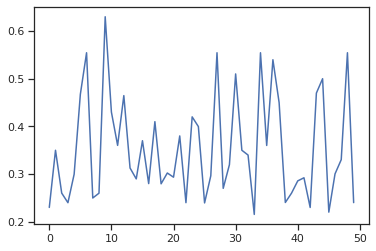

In [132]:
x = np.arange(12143)[0:50]

sns.lineplot(x=x, y=np.asarray(pred_list)[:,0][0:50])

<AxesSubplot:>

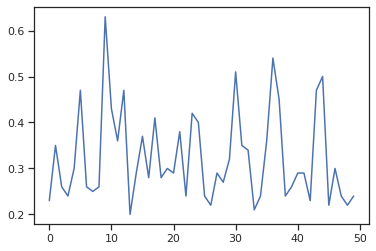

In [133]:
x = np.arange(12143)[0:50]

sns.lineplot(x=x, y=np.asarray(true_list)[:,0][0:50])

<AxesSubplot:>

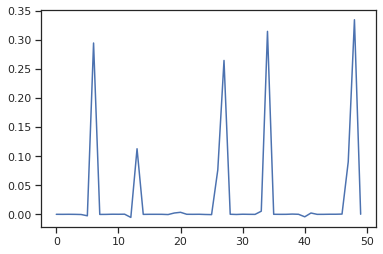

In [135]:
x = np.arange(12143)[0:50]

sns.lineplot(x=x, y=np.asarray(pred_list)[:,0][0:50] - np.asarray(true_list)[:,0][0:50])

<AxesSubplot:>

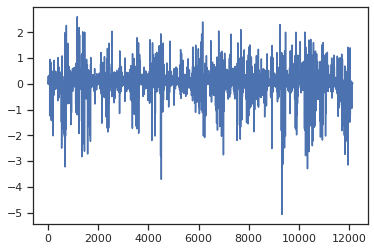

In [134]:
x = np.arange(12143)

sns.lineplot(x=x, y=np.asarray(pred_list)[:,0] - np.asarray(true_list)[:,0])

In [136]:
aa = np.asarray(pred_list)[:,0] - np.asarray(true_list)[:,0]

In [146]:
print(aa.min())
print(aa.max())
print(np.absolute(aa).mean())




-5.072784135522639
2.608591991182706
0.07661258172375152


In [152]:
np.absolute(aa).argmax()

9323

In [149]:
aa[9323]

-5.072784135522639

In [153]:
print(np.asarray(pred_list)[:,0][9323])
print(np.asarray(true_list)[:,0][9323])

print(np.asarray(pred_list)[:,0].max())
print(np.asarray(true_list)[:,0].max())



0.5872158644773611
5.66
5.919564744796381
5.92


In [332]:
t = 0
train_x = dataset_x[t][0:8500]
train_y = dataset_y[t][0:8500]

test_x = dataset_x[t][8500:]
test_y = dataset_y[t][8500:]

print(train_x.shape)
print(train_y.shape)
print(train_x[0].shape)
print(train_y[0].shape)
print(dataset_x[t].shape)
print(dataset_y[t].shape)

(205, 10)
(205,)
(10,)
(1,)
(12144, 10)
(12144,)


In [ ]:
"""
#save models
import pickle

file = open("pretrained.pickle", 'wb')
pickle.dump(clf, file)
file.close()

file = open("pretrained.pickle", 'rb')
clf = pickle.load(file)
file.close()
"""

In [ ]:
# Python:
#!python3 --version

# Pip:
#!pip --version

# matplotlob, numpy, pandas, sklearn, scipy, seaborn
import matplotlib
#print('The matplotlib version is {}'. format(matplotlib. __version__)) 
import numpy as np
#print('The numpy version is {}.'.format(np.__version__))
import pandas as pd
#print('The pandas version is {}.'.format(pd.__version__))
import sklearn
#print('The scikit-learn version is {}.'.format(sklearn.__version__))
import scipy
#print('The scipy version is {}.'.format(scipy.__version__))
import seaborn as sns
#print('The seaborn version is {}.'.format(sns.__version__))

from scipy.stats import skew
from scipy.stats import kurtosis

In [ ]:
dd1 = pd.read_csv("sample_data/consumption.csv", index_col=None)
dd2 = pd.read_csv("sample_data/generation.csv", index_col=None)

dd1['generation'] = dd2['generation'].copy()

In [ ]:
dd1['time'] = pd.to_datetime(dd1['time'])
dd1.set_index('time', inplace=True)


dd_all = []

for i in range( 24 ):
    dd_all.append( dd1.loc[dd1.index.to_series().dt.hour == i] )

for i in range( 24 ):
    dd_all[i] = dd_all[i].resample('1440T').agg({'min', 'max', 'sum', skew, kurtosis})

test_XX = []

for t in range( 24 ):
    tmp_x = []
    for i in range( len(dd_all[t]) - 6):
      tmp_x.append(dd_all[t].reset_index().drop('time', axis=1).iloc[ (i) : (i+7) ].values.flatten())
      
    test_XX.append(tmp_x)

for i in range( 24 ):
    test_XX[i] = np.asarray(test_XX[i])

In [ ]:
for t in range( 24 ):
    clff[t].predict(test_XX[t])

In [ ]:
test_XX[0]

In [ ]:
tmp_x

In [ ]:
dd3